# Basic Image Processing(5)

---

## 1.[특징점 검출](section1)

<img src="./images/day5/특징점1.PNG" width = "600" height = "600">
지역 특징점 검출 문제는 서로 대응하는 점을 찾아야 하는데, 이것을 **대응점 찾기 문제**라고 부른다. 대응점 찾기 문제는 특징점 검출(Detection), 기술(Description), 매칭(Matching)이라는 세 단계를 거쳐 해결한다. 요번 자료에서는 특징점 검출과 기술단계까지 살펴보고 다음 단계에서 매칭 단계를 살펴볼 예정이다.


특징점 검출 문제에 대해서 얘기하기 위해서는 역사에 대해서 잠시 언급을 해야한다. 기존에 많은 사람들은 매칭문제를 해결하기 위해서 고민을 많이 하였는데 가장 쉽게 생각할 수 있는 방법은 바로 엣지를 특징점으로 활용하는 것이였다. 하지만 엣지를 특징점으로 활용해서 물체를 검출하거나 매칭에 활용하기에는 엣지가 가진 정보가 턱없이 부족했다. 그래서 생각한 것이 바로 엣지화소를 연결하여 얻은 **에지토막**에 의지하였다.

<img src="./images/day5/에지토막.PNG" width = "150" height = "150">


엣지 토막을 이용하여 특징점을 검출하는 기본원리는 엣지토막에서 곡률(Curvature)이 큰 지점을 찾고 그것을 코너(Corner)라는 특징으로 취하는 것이였다. 하지만 에지토막은 디지털 공간에 정의된 곡선이므로 곡률을 계산하는데 어려움이 발생한다. 


이에 대한 대안으로 나온 것이 바로 **지역특징**이다. 지역특징(Local Feature)은 에지에 의존하는 대신 명암영상에서 직접 검출한다. 엣지에 의존하던 방법은 검출된 코너가 실제 물체의 코너에 해당해야하는 물리적으로 완고한 입장이였다. 반면 새로운 대안(지역특징)은 검출된 특징의 물리적 의미에 신경을 쓰지 않고, 대신 한 영상에서 검출된 특징이 다른 영상에서도 또 검출되기만 하면 된다는 입장을 취하였다. 즉 특징의 물리적 의미보다 **반복성**을 더 중요하게 보았다. 의식전환에서 시작된 방법론의 변화는 지역특징이라는 새로운 물줄기를 만들었고 컴퓨터 비전에 큰 공헌을 하였다. 



지역특징은 종류에 따라 조금씩 다르지만 대략 <위치,스케일,방향,특징벡터> 정보로 구성되며, 검출단계는 위치와 스케일, 기술단계는 방향과 특징벡터를 알아낸다. 이때 검출은 여러변환에 **불변(invariant)** 이어야 한다.

---

### 불변(invariant)

<img src="./images/day5/불변.PNG" width = "400" height = "400">


---



### 지역특징의 조건
지역특징을 다양한 응용에 유용하게 활용하기 위해선 몇 가지 특성을 만족해야한다.


- 반복성(Repeatability) : 같은 물체를 다른 시점에서 찍은 두 영상이 주어졌을때, 한 영상 속 물체에서 검출된 특징은 다른 영상의 물체에서도 **동일한 위치에 동일한 속성값**으로 검출되어야 한다.


- 분별력(Distinctiveness) : **물체의 다른 곳과 충분히 구분될 수 있을 정도로 두드러진 속성값을 가져야 한다.**. 그래야 실제 대응이 되는 두 점이 유일하게 1:1로 매칭될 수 있다.


- 지역성(Locality) : 어떤 점을 중심으로 **작은 크기의 주변 영역만 보고 특징검출과 특징기술이 수행되어야 한다.** 이는 다양한 형태로 가림(Occulution)과 혼재(Clutter)가 발생하는 상황에서 강건하게 작동하기 위해서 필수적이다.


- 정확성(Accuracy): **검출된 특징은 정확한 위치에 놓여야 한다.** 스케일 공간에서 찾은 특징은 2차원 공간뿐 아니라 스케일 축에서도 정확해야한다. 상황에 따라 부분 화소 정확도(Subpixel Accuracy)까지 계산할 필요가 있다.


- 적당한 양: 어떤 물체의 자세(Pose)를 계산하기 위해서는 이론적으로 세 개의 대응점만 있으면 된다. 하지만 대응점에 오류가 포함될 가능성이 있으므로 대응점이 많아지면 보다 정확하게 자세를 추정할 수 있다. 하지만 너무 많아도 계싼하는 데 시간이 오래 걸릴뿐 아니라 틀린 매칭이 자주 발생할 수 있다. **즉 너무 적어도, 많아도 안되고 적당량 있어야한다.**



### 1.1 모라벡 알고리즘
모라벡은 주변의 특징점을 검출하기 위해서 밝기변화가 큰 지역에는 높은 값을 변화가 없는 지역에는 낮은 값을 부여하는 함수를 SSD(Sum of Squared Difference)방식을 통해서 만들었다. 

$S(u,v) = \sum\sum w(x,y)(f(x+u,y+v)-f(x,y))^2$
컨볼루션은 현재 화소에서 한 개의 값만 생성하는 반면, 위 식은 $(u,v)$ 값을 변화 시켜가며 마스크 화소 각각에 대해 값을 생성한다. 


S값은 어떤점이 다른 곳과 얼마나 두드러지게 다른지 측정해 주는 역할을 한다. 물체의 코너는 두드러지게 다른 곳이므로 S를 코너일 가능성 정보로 해석할 수 있다.

<img src="./images/day5/모라벡1.PNG" width = "450" height = "450">

위 의 그림에서는 모라벡 알고리즘의 S값을 통해서 어떻게 corner를 찾는지 보여주는 그림이다. a는 corner, b는 edge ,c는 flat이다. a점이 있는곳에서의 S값을 보면 모든방향으로 값이 큰 것을 알 수 있다. b의 값을 보면 한쪽 측면의 값이 높지 않은 것을 알 수 있고, 마지막으로 c는 값이 없다.

<img src="./images/day5/모라벡2.PNG" width = "600" height = "600">



위 그림을 보면 a는 코너 b는 edge ,c는 flat지점인 부분에서 S값을 오른쪽 a,b,c그림으로 나타내었다. a부터 살펴보면 가운데 검은점을 중심으로 두변에 값의 변화가 많은 것을 알 수 있다. b는 두방향에 대해서는 값의 변화가 두드러지지만 한쪽방향으로는 값의 변화가 거이 없다. c는 주변의 밝기 변화가 없다.


따라서 모라벡은 어떤 점이 코너라면 네 방향 모두 변화가 커야 한다고 보고, 네 값의 최솟값을 지역 특성일 가능성 값으로 간주 하였다. 

$ C = min(S(1,0),S(-1,0),S(0,1),S(0,-1))$




[예제코드](#section3)

---



### 1.2 해리스 코너

해리스 코너는 잡음에 대처하기 위해 박스형 가우시안 마스크 $G(x,y)$를 이용하여 가중치 제곱합 WSSD(Weighted Sum of Squared Difference)로 확장시켰다. 

$S(u,v) = \sum\sum G(x,y)(f(x+u,y+v)-f(x,y))^2 $

위식을 자세하게 살펴보면 기존에 모라벡의 S식에서 $W(x,y)$ 부분이 $G(x,y)$로 대체된 것이 외에는 같은식이다. 
해리스코너는 한가지 단점이 있는데 등방향성(isotropic property)을 만족하지 못하여서 결국 물체가 0도 90도 270도 만큼 회전하면 적절히 대처가능하지만 32도 48와 같이 임의의 값만큼 회전하는 경우 대처 불가능하다. **즉 제한적인 회전 불변성을 지닌다**

---

<img src="./images/day5/해리스1.PNG" width = "600" height = "600">



행렬A는 자가 공관계(Auto Correlation)행렬 또는 2차 모멘트행렬(Second Moment Matrix)이라 불린다. 위의 식을 자세하게 보면 마지막부분에 S(u,v) 부분에서 식이 인수분해 되어 (u,v)와 A가 분리되어 있다. 즉 A는 (u,v)와 무관하게 계산할 수 있다. A가 현재 위치의 영상구조를 말해주게 되어 맵을 S값을 산출하지 않아도 A만 잘 들여다보면 현재 위치의 영상구조를 파악하여 특징여부를 파악할 수 있다. 


왼쪽식의 빨간 박스부분을 보면 2X2행렬이 존재하는데 이 행렬의 두 고유값을 $\lambda1 ,  \lambda2$라하면 $\lambda1$의 고유벡터 방향으로 shift시킬 때 최대가 되고,$\lambda2$ 고유벡터 방향으로 shift시킬 때 최소가 된다. 따라서 $\lambda1, \lambda2$는 해당 고유벡터 방향으로의 실제 영상 변화량 값이 된다.


$\lambda1,\lambda2$ 를 구했을 때, 두 값이 모두 큰 값이면 Corner, 모두 작은 값이면 Flat, 하난는 크고 다른 하나는 작은 값이면 Edge영역으로 판단 할 수 있다. 위 식을 효율적으로 바꿔서 코너점 여부를 판단하는 C를 만들면

$C = \lambda1*\lambda2 - k(\lambda1+\lambda2)^2  = det(A)- k*trace(A)^2 $

C >0 이면 코너점, C<0 이면 Edge, $ |C|$ 이 매우 작으면 flat으로 판단한다.

<img src="./images/day5/해리스2.PNG" width = "450" height = "450">


[예제코드](#section4)

---



### 1.3 2차미분
앞에서 살펴본 내용은 1차 도함수$d_x$와 $d_y$로 정의되는 2차 모멘트 행렬을 사용하였다. 특징점을 구하는 또 다른 방법을 살펴보면 


<img src="./images/day5/2차미분1.PNG" width = "200" height = "200">


해시안 행렬을 2차 미분을 한 식이다. 미분한 것은 잡음을 증폭시키는데, 두번 미분을 하게 될 경우에는 문제가 더욱 심해지므로 2차 도함수를 그대로 사용하는 것이 아니라 가우시안 스무딩을 진행한 뒤 그 결과에 2차 미분을 수행한다.


$C = det(H) = dxx(\sigma)dyy(\sigma) - (dxy(\sigma))^2$


$C = trace(H) = dxx(\sigma) + dyy(\sigma)$


위의 식은 기존에 살펴본 LOG(Laplacian Of Gaussian)와 같다. 이 연산자는 에지에 민감하게 반응하므로 에지 근방에서 특징점이 많이 발생한다. 에지를 걸러주는 후처리과정을 거치면 특징점만 남길 수 있다.

[예제코드](#section5)

---


### 1.4 스케일에 불변한 특징점 추출 - 1스케일공간


<img src="./images/day5/스케일1.PNG" width = "500" height = "500">


같은 물체가 서로 다른 두 영상에 다른 크기로 나타날 때 어떻게 하면 같은 특징을 얻어 낼 수 있을까 ?

대표적인 방법으로 두 가지 방법이 있다.

<img src="./images/day5/스케일2시그마.PNG" width = "500" height = "500">
1. $\sigma$ 값을 변화시키며 영상을 Smoothing
    - 거리가 멀어지면 물체의 세밀한 내용은 사라지고 윤곽은 점점 흐릿해지는 원리를 이용한 방법이다. Gaussian Filter에서 $\sigma$값을 점점 키워가며 Smoothing 연산을 하여서 거리가 멀어지는 효과를 모방한다.
    
<img src="./images/day5/스케일3피라미드.PNG" width = "500" height = "500">    
2. 주어진 영상의 해상도를 점점 줄여 다중 스케일 영상을 구축
    - 영상의 해상도를 반으로 줄여나감으로써 영상피라미드를 구축하는 방식, 거리가 멀어지면 물체의 크기가 작아지는 효과를 모방
    
    
    
위 두가지 방법들중 해상도를 줄여나가며 영상피라미드를 구축하는 방식은 두배씩 작아져 한계가 존재한다. 반면 첫 번째 방식은 Gaussian Filter에서 $\sigma$로 Scale값을 조절하는데 $\sigma$가 연속공간에 정의되므로 임의의 스케일에 대처할 수 있다는 장점이 있다.이러한 이유로 영상피라미드 구축하는 방식보다 Gaussian Smoothing을 통해 Scale Space를 구축하는 방식이 더 많이 사용된다.

---

#### 1.4-1 스케일 공간에서 3차원 극점 탐색

<img src="./images/day5/3차원극점.PNG" width = "500" height = "500">    

위 식은 다중 스케일 영상에 Laplacian을 적용한 결과이다. 정규라플라시안 식은 라플라시안에 $\sigma^2$을 곱한식이다. 정규화를 하는 이유는 라플라시안을 구성하는 dxx와 dyy가 $\sigma$가 클수록 작아지기 때문에 이런 현상을 보완하기 위해 $\sigma$을 곱한다.

<img src="./images/day5/blob찾기.PNG" width = "500" height = "500">    


위 이미지를 보면 Blob을 찾기위해 정규라플라시안을 하여 극점을 찾는데 $\sigma$ 값에 따른 Blob들의 이미지를 보여준다. 작은 Blob은 $\sigma$ 값이 3.59일때 최대점이고 큰 Blob은 $\sigma$ 값이 5.5일때 최대 이다. 이처럼 정규라플라시안을 사용하면 여러 점들을 Trade off를 설정하여 두 극점을 적절하게 찾아낼 수 있다. 

[예제코드](#section6)

---


#### 1.4-2 스케일에 불변한 특징점 검출 - 해리스 라플라스 특징검출
해리스 라플라스 알고리즘은 극점 탐색과정에서 2차원 영상공간과 스케일축을 구분하여 취급한다는 점에서 다르다. 영상공간에서는 기존에 살펴봤던 해리스가 제안한 식을 사용하지만 스케일축에서는 극점을 제대로 찾지 못하기 땜누에 다음과 같이 식을 약간 변형한다.

<img src="./images/day5/해리스라플라스.PNG" width = "500" height = "500">    


2x2행렬의 첫번째 요소dy는 원래 영상을 $\sigma_D$크기의 가우시안으로 스무딩한 후 y방향으로 한번 미분함을 뜻한다. 위 식은 그것을 제곱한 영상에 $G(\sigma_I)$ 크기의 가우시안으로 다시 스무딩한 결과에 $\sigma^2_D$을 곱한다. $Ascalespace$ 행렬을 바탕으로 특징 가능성을 나타내는 식을 도출하면 아래와 같다. 스케일을 나타내는 매개변수$\sigma_D$를 포함하므로, 매개변수를 변화시키며 원하는 스케일에서 특징 가능성 값을 구할수 있다.

$C = det(Ascalespace) - k*trace(Ascalespace)^2 = (pq-r^2)-k(p+q)^2$




---


### 1.5 SIFT
SIFT(Scale-Invariant Feature Transform) Sift 알고리즘은 기존의 Harris corner가 영상의 스케일 변화에 민감한 문제를 해결하기 위해 DOG(Difference of Gaussian)를 기반으로 이미지 내에서 뿐만아니라 스케일 축으로도 코너성이 극대인 점을 찾는다.


<img src="./images/day5/sift1.PNG" width = "500" height = "500">    



스케일 공간을 구성하는 방법은 옥타브를 여러개 구성하는 것인데 한 개의 옥타브 내에서 여러 $\sigma$ 값을 점점 키우며 영상을 스무딩한다. 옥타브 내에서 4번째 영상에서 해당 이미지를 절반의 크기로 나눈뒤 구한 이미지를 통해 새로운 옥타브를 구성하는 방식으로 여러 옥타브의 스케일 공간을 구축한다. 


<img src="./images/day5/sift2dog.PNG" width = "500" height = "500">    
SIFT는 특징점을 정규라플라시안 맵에서 찾지만 DOG(Difference Of Gaussian)을 사용하는데 이 식은 정규라플라시안과 매우 유사하다.
위 식을 보면 DOG의 장점을 알 수 있는데, DOG는 두 장의 스무딩 된 영상의 차를 계산한다. 라플라시안 식에서는 컨볼루션을 해야하지만 DOG는 화소값의 차만 구하면 되기 때문에 계산시간이 수십배에서 수백배 빨라진다. 


<img src="./images/day5/sift3극점찾기.PNG" width = "500" height = "500">    
DOG 피라미드가 완성되면 3차원 공간에서 극점을 찾는 일을 시작한다. X표시된 점을 탐색을 할 때 X의 26개의 이웃점에 비해 최소 또는 최대가 되면 극점으로 하여 특징점으로 취한다. 일정한 임계값을 설정하여 임계값보다 작은 극점은 잡음으로 간주하여 버린다. 이렇게 검출된 특징점을 $(x,y,o,i)$의 정보를 가진다. O는 옥타브 번호 i는 DOG번호

[예제코드](#section7)

---


### 1.6 SURF(Speeded-Up Robust Feature)
SIFT 알고리즘 이후에 속도를 개선하려는 목적으로 여러개의 변종 알고리즘이 탄생하게 됐다. SURF(Speeded-Up Robust Feature)는 해시안 행렬식을 이용하여 쉽게 생각할수 있는 방식이다.

<img src="./images/day5/surf1.PNG" width = "500" height = "500">    
해시안 행렬을 이용하여 C라는 특징점을 판단하는 점수지표를 만들 수 있다. 하지만 SURF에서는 계산속도를 개선하기 위해서 아래와 같이 식을 조금 바꾸는데 캡


<img src="./images/day5/surf2.PNG" width = "500" height = "500">    
SURF는 dyy를 근사화한 Dyy를 빨리 계산하기 위해 적분영상(Integral Image)을 사용한다. Dyy는 값이 1인 3X5 블록  2개, -2인 3X5블록 한개 그리고 0인 블록 9X2블록 두개로 구성된다. SIFT는 여러 개의 옥타브로 구성되는 피라미드를 구축하기 위해 가우시안 스무딩을 많이 하지만 SURF는 원본 영상을 그대로 둔 채 근사연산자의 크기를 조절하여 스케일 공간을 구축한다. **즉 가우시안 스무딩 연산을 하지 않는다** 
값이 1인 두 블록의 합을 a1과 a2라 하고, -2인 블록 합을 b라 하면 Dyy는 a1+a2-2b이다. 

<img src="./images/day5/surf3.PNG" width = "500" height = "500">    

위 그림의 방식을 반복적으로 적용하여 9x9 -> 15x15 -> 21x21 -> 27x27크기의 연산자를 제작하고 이들을 원래 영상에 적용하여 네 개의 스케일에 해당하는 영상 집합을 만든다. 각 스케일에서 앞에서 언급했던 행렬식 영상이 한 옥타브를 형성하는데 중간에 있는 15x15와 21x21크기의 연산자로 만든 두 영상에 대해 같은 과정을 적용하여 지역 극점을 검출한다. 

[예지코드](#section8)

---


## 2.[특징 기술](section2)
특징이 매칭이나 인식과 같은 단계에서 유용하게 쓰이려면, 두 가지 요구 조건을 만족해야한다.
1. 분별력(Discriminating Power)가 높아야한다.
2. 다양한 변환에 불변(Invariant)한 속성을 가져야한다.

<img src="./images/day5/특징기술.PNG" width = "500" height = "500">    

앞서 살펴본 특징 검출에서는 Scale에 대한 invariant나 Harris Corner에서 rotation에 대한 invariant만 살펴봤지만 검출된 특징들을 이용해서 특징기술에 이용되기 위해서는 회전+축소, 찌그러짐과 같은 변환에도 Invariant한 속성을 가지고 있어야한다.

---

### 2.1 관심점을 위한 기술자 SIFT
앞서 설명한 SIFT는 스케일에 불변한 특징을 만들기 위한 과정을 보여주었다. SIFT에서 검출한 특징점을 Keypoint라고 부르는데 이 Keypoint는 위치와 스케일 정보를 담은 $(x,y,\sigma)$로 표현한다. 여기서 스케일을 뜻하는 시그마 정보를 이용하여 크기변환에 대처할 수 있다. 이 때 두가지 사항을 고려해야한다.첫째는 윈도우 크기를 $\sigma$에 따라 조절하는 것이고, 둘째는 $\sigma$에 따라 영상을 스무딩하는 것이다.


회전변환에 문제를 하기위해 SIFT는 기술자를 추출하기 이전에 지배적인방향(Dominant Orientation)을 먼저 찾는다. 특징점에 대해 방향히스토그램을 구하고, 가장 강한 방향을 특징점의 방향으로 결정한다. 최고값의 0.8배 이상인 칸이 있으면 그것도 지배적인 방향으로 삼아 별도의 키포인트를 생성한다. 따라서 하나의 키포인트가 위치는 같지만 방향이 다른 여러 개로 나뉠 수도 있다. 

<img src="./images/day5/특징기술sift1.PNG" width = "500" height = "500">    


위 과정을 거치면 Keypoint는 위치와 스케일, 방향정보를 가진$(x,y,\sigma,\theta)$로 표현한다.이제 기술자를 추출하기 위해, 키포인테에 적절한 크기의 윈도우를 씌우고 이 윈도우를 4x4분할을 하여 16개의 블록으로 나눈다. 나뉜뒤에 추출을 SIFT를 통해 특징값추출을 한다. 그 뒤 한 블록은 자신이 속한 화소의 그레디언트를 계산 후 8단계로 양자화된 그레디언트 방향 히스토그램을 구한다. 지배적인 방향을 계산할때와 마찬가지로 그레디언트 크기를 가중치로 사용하며, 가우시안을 씌워 중심에서 멀어질수록 작은 가중치로 한다. 결국 4x4x8 = 128차원 특징 벡터x가 추출된다.


마지막으로 광도 불변성을 달성하기 위해 x를 벡터의 크기 $||x||$로 나눠 단위 벡터로 변환한다. 단위벡터에 0.2보다 큰 요소가 있으면 그것을 0.2로 바꾸고 다시 단위벡터로 변환한다. 이렇게 하면 스케일, 회전, 광도에 변환에 불변한 128차원 특징벡터(기술자)가 완성된다.


---



### 2.2 관심점을 위한 기술자 SIFT의 변형 PCA-SIFT
PCA-SIFT는 keypoint를 중심으로 39x39윈도우를 씌운다. 윈도우 안에 있는 화소의 x와 y방향의 도함수 $d_x,d_y$를 구한다. 그 결과 39x39x2 = 3042차원의 특징벡터를 얻는다. **이 고차원의 벡터를 PCA(Principal Component Analysis)를 사용하여 d차원으로 축소하고 그것을 특징벡터 x로 취한다.** 보통 d = 20정도를 설정하기 때문에 sift의 128차원보다 훨씬 낮은 차원의 벡터를 얻는다. 

---



### 2.3 관심점을 위한 기술자 SIFT의 변형 GLOH
SIFT와 PCA-SIFT는 정사각형 모양의 윈도우를 사용한다.GLOH(Gradient Location-Orientation Histogram)라는 기술자는 정사각형 윈도우를 원형윈도우로 대체한다.

<img src="./images/day5/GLOH.PNG" width = "200" height = "200">    

윈도우를 구성하는 세 원의 반지름은 안쪽부터 6,11,15이고 바깥쪽 두 개의 원은 여덟개 영역으로 등분된다. 이렇게 분할된 17개 영역에서 각각 16단계의 그레디언트 방향 히스토그램을 계싼한다. 따라서 17x16 = 272차원의 특징벡터가 생성된다.
이 벡터는 PCA를 이용하여 128차원으로 축소된다. 

---



### 2.4 이진 기술자


<img src="./images/day5/이진1.PNG" width = "300" height = "300">    

비디오 영상에서 물체추적과 같은 응용ㅔ서는 초당 30장의 영상을 처리해야하므로 계산효율이 매우 중요하다. 모바일 플렛폼에서 작동하는 응용프로그램의 경우에는 CPU와 메모리 성능이 낮기 때문에 앞서 소개한 기술자가 부적절할 수 있다.
한장의 영상은 수천x512byte를 사용하므로 메가바이트에 달하는 메모리를 필요로 한다. 게다가 실수로 표현되는 벡터를 매치할 때 유클리디안 거리를 계산해야한다. 게다가 실수로 표현되는 벡터를 매칭할 때 유클리디안 거리를 계산해야하므로 연산시간도 많이 걸린다. 


모든 이진 기술자는 특징점 주변에 있는 두개의 화소를 비교쌍으로 삼아, 그들의 명암값을 비교하여 0또는 1의 이진값을 생성한다.
[이미지]

이 때 비교쌍을 어떻게 구성할지가 중요하다.
이진 기술자중 3가지에 대해서 간략하게 설명을 해보면




1. BRIEF : 이 기술자는 같은 크기의 가우시안에서 비교쌍을 생성하기 때문에 스케일 변환과 회전변환에 대처하지 못한다. 스케일 불변과 회전불변성을 갖지는 못하지만 특징벡터의 비트수가 256비트로 매우 낮다.
<img src="./images/day5/이진2.PNG" width = "150" height = "150">    

2. ORB : 이 기술자는 특징점의 방향에 따라서 조사패턴을 발생시키기 때문에 회전에 대해 불변성을 갖지만 스케일 변환에 불변성을 갖지못한다. 특징벡터의 비트수는 512비트이다.
<img src="./images/day5/이진3.PNG" width = "150" height = "150">    

3. BRISK : BRISK는 특징점 주변에 60개의 점을 설정하고 이들 점의 조합을 비교 쌍으로 사용한다. 스케일과 회전에 대해서 불변성을 갖고 특징 벡터의 비트수는 512비트이다. 

<img src="./images/day5/이진4.PNG" width = "150" height = "150">    

[예제코드](#section9)

### 2.4.1 영역 기술자 - 모멘트

---



### 2.4.2 영역 기술자 - 푸리에 기술자
디지털 영상은 sampling과 quantization을 통해 데이터화가 된다. 하지만 이렇게 데이터화가 되기전에 신호를 처리하는 방법이 있는데 이런 신호를 처리하는 방법이 푸리에 기술자이다. 


<img src="./images/day5/푸리에1.PNG" width = "400" height = "400">    

$s_1(x) = 0.5g_1(x) + 2.0g_2(x)$


$s_2(x) = 2.0g_1(x) + 0.5g_2(x)$
(a)와 (b)신호를 수식화 한 것이다.s1과 s2는 다음과 기저함수(Basis Fucntion)의 선형결합(Linear Combination)으로 표현할 수 있다. 
위 그림에서는 신호를 합성하였기 때문에 미리 기저함수를 알 수 있었으나 실제로는 외부에서 관찰한 신호가 입력으로 들어오므로 기저함수의 계수를 미리 알수 없다. 


<img src="./images/day5/푸리에2.PNG" width = "400" height = "400">    
이 때 사용하는 것이 바로 이산 푸리에 변환식이다.t(u)는 선형결합에 나타난 계수 u는 기저함수의 진폭에 해당한다

푸리에 변환에서는 입력신호가 정의된i축을 공간도메인 (Spatial Domain)이라 부르고, 계수t(u)가 정의된 u축을 주파수 도메인(frequency domain)이라 부른다. 푸리에 변환은 주어진 신호를 주파수 도메인와 공간도메인을 통해서 이산형 값으로 변환을 해준다. 

$S(i) = y_i + jx_i $


위의 수식을 이용하여 복소수 표현을 사용하면 2차우너 점이 1차원이 되어, 1차원 푸리에 변환을 사용할 수 있다. 복소수로 표현한 결과를 위의 푸리에 변환에 입력으로 넣어 얻은t(u)에서 실수부와 허수부를 취하면 총 2n개의 요소를 갖는 벡터가 된다.실제로는 u가 커짐에 따라 급속도로t(u)가 작아지므로 적절한 d를 설정하고, 앞에 있는 t(0),...,t(d-1)만 특징으로 취한다. 




### 2.4.3 영역 기술자 - 텍스처

<img src="./images/day5/텍스처1.PNG" width = "500" height = "500">    

컴퓨터 비전도 영상분할이나 특징추출목적으로 텍스처를 많이 사용하지만 텍스처를 명확하게 정의하기는 어렵다. 텍스처는 간단하게 얘기하면 일정한 패턴의 반복이라 볼 수 있다. 왼쪽의 이미지를 보면 새의 배부분에서 부드러운 느낌을 주는 일정한 패턴이 반복되고있고 오른쪽의 잔디부분에서는 거친느낌의 잔디 느낌을 주고있다. 오른쪽 이미지에서는 꽃들이 있는 어떤 패턴이 있고 오른쪽 위에부분에서는 하늘의 텍스처가 있다가 나무숲이 있는 텍스처가 나타난다. 


이러한 텍스처를 분석하는 가장 직관적이고 이해하기 쉬운 접근방법은 구조적 방법(Structural method)이다. 구조적 방법은 텍셀(texel)이라 부르는 기본요소를 추출한 후, 텍셀의 공간적인 배열을 찾는다. 자연 영상은 텍셀추출이 어려울 뿐 아니라 공간적 관계를 표현하는 일도 쉽지 않다. 대부분의 텍스쳐 분석방법은 통계적 접근방법을 사용한다. 

---



### 2.4.3.1 영역 기술자 - 텍스처 - 전역기술자


<img src="./images/day5/텍스처2.PNG" width = "300" height = "300">    

1) 에지기반의 영역 기술자는 위의 T를 구해서 판단할 수 있다. Busy라는 특징은 영역에 있는 에지화소의 비율, MAg(i)는 에지 화소의 에지강도를 q단계로 양자화하여 구한 히스토그램 dir(i)는 8-방향으로 양자화된 에지 방향 히스토그램이다. 

2) 명암 히스토그램 기반 
텍스처를 나타내는 또 다른 방법은 영역을 구성하는 화소의 명함히스토그램을 이용하는 것이다. 정규명암 히스토그램을 h(l), l= 0,1,...,L-1이라 하자.
<img src="./images/day5/텍스처3.PNG" width = "300" height = "300">    

오른쪽의 T라는 값을 통해서 텍스처 기술자를 구성할 수 있는데, parameter에 대해서 간단하게 설명을 해보면 smooth는 각각 영역의 부드러운정도를 나타내고 skew는 히스토그램이 밝은쪽과 어두운쪽 중 어느쪽에 치우쳤는지를 말해준다. uniform은 영역이 얼마나 균일한지 측정해주고 entropy는 반대로 영역이 얼마나 변화가 심한지 알려준다. 


[예제코드](#section10)


---


<a id='section10'></a>

#### 문제점 
<img src="./images/day5/전역기술자문제점.PNG" width = "500" height = "500">    

앞서 소개한 두 기술자는 원시적인 형태이기도 하거니와 전역정보만 표현하고 있어 지역적인 변화는 전혀 반영하지 못하는 한계가 있다. 명암히스토그램을 사용하여 기술자를 추출하는 위 그림과 같은 경우 영상히스토그램이 똑같은 값을 갖기 땜누에 변별력이 없다. 에지 정보를 쓰는 식은 기술자를 절대 값은 다르지만 상대적인 비율은 서로 같기 때문에 실제로는 분별력이 거의없다. 

---



### 2.4.3.2 영역 기술자 - 텍스처 - 지역기술자
1) 동시발생행렬

<img src="./images/day5/지역기술자.PNG" width = "500" height = "500">    


위 그림은 동시 발생행렬(co-occurrence matrix)을 보여준다. 동시발생행렬을 구성하기 위해서는 두 화소의 이웃관계를 규정해야하는데 현재 화소값과 오른쪽화소값으로 구성하면 위 그림의 오른쪽처럼 동시발생 행렬을 구성할 수 있다. 행은 현재 화소값 열은 오른쪽 화소값 이다. 


명암 영상은 대부분 L = 256이기 때문에 256x256의 큰 행렬이 만들어지는데, 보통 L단계를 q단계로 양자화하여 사용한다. ex) (q가 8이면 0~31은 0, 32~63은 1로 매핑된다.)


동시발생행렬을 O라하고 (i,j)에 있는 요소를 Oij로 표기하자.(n은 전체화소 쌍의 수)
<img src="./images/day5/지역기술자3.PNG" width = "150" height = "150">    

위 행렬 O는 텍스처를 측정하기 위한 유용한 정보를 담고 있는 것은 확실하지만, 그 자체를 텍스처 기술자로 취할 수는 없다. 따라서 아래의 값들을 구해서 텍스처 기술자로 이용한다.
<img src="./images/day5/지역기술자2.PNG" width = "500" height = "500">    



[예제코드](#section11)



2) 지역이진패턴(Local binary Pattern)


<img src="./images/day5/lbp.PNG" width = "500" height = "500">    



LBP는 왼쪽의 이미지처럼 Convolution에서 중앙의 있는 값과 그 외의 값들을 비교한 뒤 작으면 0 크면 1의 값으로 변환을 하게 된다. 그 후 가운데 있는 이미지 순서대로 이진화를 하게되고 이 값을 다시 십진수로 표현하는 과정을 거친다.
이렇게 만들어진 십진수 정수의 값에 대하여 히스토그램을 통해 구하면 지역이진패턴 LBP(Local Binary Pattern)이라는 텍스처 기술자가 완성된다. LBP는 256차원의 특징벡터이다. 



#### LBP의 단점
<img src="./images/day5/lbp2.PNG" width = "300" height = "300">    
LBP는 명암이 비교적 균일한 부근에서 불안점한 단점이 존재한다. 위의 이미지를 보면 가운데있는 픽셀의 값은 150이고 150값을 중심으로 그것보다크면 1 그것보다 작으면 0으로 값을 바꿔야한다. 하지만 위 그림처럼 150에서 큰차이가 나지않고 noise 때문에 얼마차이가 나지 않는 값을 가지고있지만 LBP를 이용하게되면 1차이나는것도 0과1로 코딩이 되기 때문에 엄청 차이가 있는것으로 인식된다.

#### LTP(Local Ternary Patter)는 이러한 단점을 개선한 방법이다.
<img src="./images/day5/ltp.PNG" width = "500" height = "500">    
LBP에서 약간 변형된 방식으로 LTP에서는 매개변수 t를 설정하게 된다. 매개변수 t를 가운데 픽셀값에서 더하면 155의 값을 갖게되고 빼면 145의 값을 갖는다. 이때 145보다 작은 값은 -1, 155보다 큰 이웃은 1, 그리고 [145 ,155]사이의 이웃은 0이라는 코드를 갖게 된다. 결국 LTP는 두개의 LBP를 결합한 꼴이다. 따라서 256개의 칸을 가진 두개의 히스토그램이 생성되므로 LTP는 512차원의 특징벡터가 된다. 

[예제코드](#section12)

### 2.4.4 영역기술자 - 주성분 분석


<img src="./images/day5/pca.PNG" width = "200" height = "200">    
위 그림에 있는 얼굴 영상을 위한 적절한 기술자는 무엇일까? 얼굴인식이 목적이라면 사실 앞의 어느 기술자도 마땅치 않다. 화소값 자체를 특징으로 삼게 된다면? 화소가 600x450개 이므로 270,000차원의 거대한 특징벡터가 생성된다. 굉장히 어마어마하게 많은 양이다. 



<img src="./images/day5/pca2.PNG" width = "500" height = "500">    
PCA(Principal Component Analysis)는 위의 표처럼 학습집합으로부터 변환행렬을 추정하여 변환하고싶은 y값에 대한 식을 도출한다. 그리고 x값을 input으로 넣어 특징벡터인 y를 얻어 내는 구조이다. PCA는 입력 x를 보다 낮은 차원의 특징벡터y로 변환하는 것이 목적인데, 차원이 줄면 당연히 정보손실이 일어난다. 따라서 **PCA의 목적을 정보손실을 최소화하며 차원을 줄이는것**으로 규정할 수 있다. 


PCA의 목적을 달성하기 위해서는 두 가지에 대한 수학적인 공식화가 필요하다. 
1. 차원을 축소하는 방법
2. 정보손실을 수량화하는 방법



<img src="./images/day5/pca3.PNG" width = "500" height = "500">    
위그림을 보면 u라는 축으로 input data $(x1,x2,x3,x4)$의 데이터를 축소를 시킬 것이다. 위의 이미지에서 비어있는 동그라미는 input data , 색이 칠해져있는 동그라미는 차원을 축소시킨 data이다. 차원을 축소시킨 data를 보면 첫번째 그림은 2개, 두번째는 3개, 3번째 그림에서는 4개가 남아있다. 원래 input의 개수를 생각해보면 처음에 입력한 데이터의 개수는 4개인데 차원을 축소(투영)을 하고 난후에 데이터를 보면 2,3,4개로 각각 다르다. 즉 첫번째 두번째 그림에서 차원을 축소하는 과정에서 데이터의 손실(정보의 손실)이 발생하게 된다.


즉 우리가 해야하는 작업은 데이터의 차원을 축소시켰을때 데이터들이 가능한 많이 축소시키는 축위에 가장 많이 존재하게끔 만드는 것이고 이는 분산을 크게만드는것과 같다. 


<img src="./images/day5/pca수식1.PNG" width = "500" height = "500">    

<img src="./images/day5/pca수식2.PNG" width = "500" height = "500">    
분산식은 위와같이 되어있는데 식을 잘들여다보면 u가 클수록 분산이 커진다. 결국 PCA는 분산을 최대화 하면서 차원을 축소시키는 것을 의미한다. 이런 최대화 문제를 풀기 위해서 라그랑지승수를 이용해서 수식을 풀게된다.



<img src="./images/day5/pca수식3.PNG" width = "400" height = "400">    
이 라그랑주 함수$L(u)$를 u로 미분을 하고 수식을전개하면 위와 같이 전개가 된다. 위에서 구한 $L(u)$를 최대화하는 미분한 값이 0임을 만족해야한다. 따라서
$\Sigma u^T = \lambda u^T $라는 식이 만들어 지게된다. 지금까지는 하나의 축으로 투영하는 상황이지만 우리가 실제로 접하는 데이터는 D차원을 d차원으로 줄이는 것이 목적이기 때문에 d개의 축을 찾아야한다. 공분산행렬은 DxD의 정방행렬이고 고유벡터는 D개가 존재한다. 고유벡터의 성질에 따라서 이들은 모두 단위벡터이며 Orthogonal하기 때문에 고유값을 기준으로 정렬한 후, 사위 d개의 고유벡터를 선정하면 된다. 이들을 $u_1,...,u_d$로 표기하고 이들을 주성분이라 한다. 
$y^T = Ux^T$




### 2.5 PCA의 적용
컴퓨터 비전에서 PCA를 가장 혁신적으로 활용한 사례는 얼굴인식이다. 
얼굴인식을 하기 위해서 가장 먼저할일은 이들의 평균을 취해 평균얼굴을 만들고 covariance matrix를 구한다. 
<img src="./images/day5/적용1.PNG" width = "500" height = "500">    
평균얼굴을 만든 것을 보면 여러사람의 얼굴을 합쳤지만 괴물의 모습을 하고있지는 않다.눈과 입의 위치가 대략 일치하고 조명은 비슷해야하기 때문에 적절히 변환해주는 전처리를 미리한 뒤에 값들을 계산을 진행한다. 그 후에 얼굴영상을 PCA에 input으로 입력할 수 있도록 벡터의 형태로 변환하여 표기한다. 벡터x는 D차원 공간위의 한점으로 간주할 수 있으므로 앞절에서 공부한 PCA를 그대로 적용할 수 있다. 앞서 계산한 공분산 행렬을 이용해서 고유벡터와 고유값을 계싼한다. 공분산행렬이 MN x MN이므로 MN개의 고유벡터가 얻어진다. 차원을 축소하기 위해 MN개의 고유벡터중 고유값이 가장 큰 d개만 선택한다. 선택된 고유벡터를 고유값이 큰 순서에 따라 $u1,u2,...,u_d$라 표기하고 순서대로 행렬 U에 배치하낟.

<img src="./images/day5/적용2.PNG" width = "500" height = "500">    
위 이미지는 고유값의 크기 순서대로 영상을 변화시킨 것이다. 위에서 보는 바와 같이 고유벡터는 얼굴형태를 띄고 고유값이 큰 벡터일수록 얼굴 형태가 뚜렷하다.이를 마지막 단계에서 벡터간의 거리를 계산하는 과정을 넣어 사람을 인식하는 문제로 적용시켜보면 새로운 input data가 들어왔을때 그영상과 미리 만들어놓은 고유얼굴표현과의 거리를 계산하여 거리가 가장 짧은 사람으로 분류하는것으로 인식문제에 PCA를 적용시킬 수 있다. 

In [91]:
from skimage.feature import greycomatrix, greycoprops

# Moravec Coner

<a id='section3'></a>

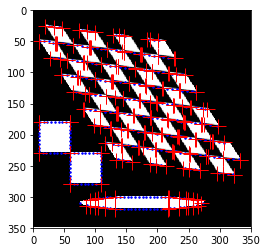

In [176]:
from matplotlib import pyplot as plt

from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks , corner_moravec
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse


tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,
                        translation=(210, 50))
image = warp(data.checkerboard(), tform.inverse, output_shape=(350, 350))
rr, cc = ellipse(310, 175, 10, 100)
image[rr, cc] = 1
image[180:230, 10:60] = 1
image[230:280, 60:110] = 1

coords = corner_peaks(corner_moravec(image), min_distance=5)
coords_subpix = corner_subpix(image, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], '.b', markersize=3)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 350, 350, 0))
plt.show()

# Harris Corner

<a id='section4'></a>

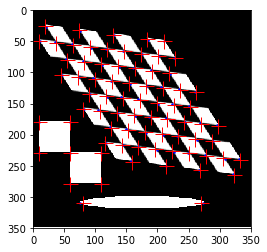

In [2]:
from matplotlib import pyplot as plt

from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse


tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,
                        translation=(210, 50))
image = warp(data.checkerboard(), tform.inverse, output_shape=(350, 350))
rr, cc = ellipse(310, 175, 10, 100)
image[rr, cc] = 1
image[180:230, 10:60] = 1
image[230:280, 60:110] = 1

coords = corner_peaks(corner_harris(image), min_distance=5)
coords_subpix = corner_subpix(image, coords, window_size=13)

fig, ax = plt.subplots()
ax.imshow(image, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], '.b', markersize=3)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 350, 350, 0))
plt.show()

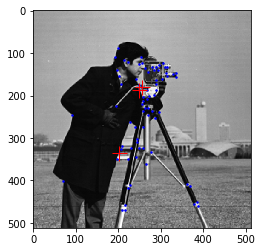

In [42]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import corner_harris, corner_subpix , corner_peaks
image = rgb2gray(image)
corners = corner_harris(image)  # 이미지에 있는 코너를 계산 
coords = corner_peaks(corners, min_distance =5)
coords_subpix = corner_subpix(image, coords , window_size=13)


fig, ax = plt.subplots()

ax.imshow(image, interpolation = "nearest", cmap = plt.cm.gray)
ax.plot(coords[:,1], coords[:,0],'.b',markersize = 3)
ax.plot(coords_subpix[:,1],coords_subpix[:,0],'+r',markersize = 15)
plt.show()

# DOH(Determinant Of Hessian Method)

<a id='section5'></a>

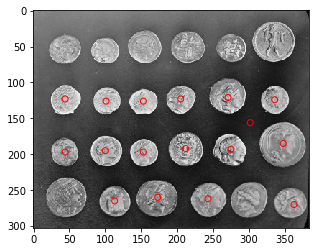

In [144]:
from skimage import data, feature
img = data.coins()
key = feature.blob_doh(img)

plt.imshow(img)
plt.scatter(key[:,1],key[:,0],facecolors = 'none',edgecolors = 'r')

# Blob_log(Laplacian of Gaussian Method)

<a id='section6'></a>

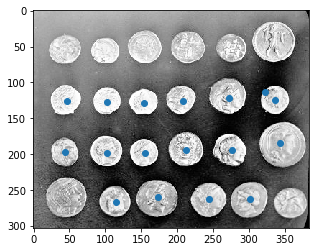

In [97]:
from skimage import data, feature, exposure
img = data.coins()
img = exposure.equalize_hist(img)  # improves detection
key = feature.blob_log(img, threshold = .3)

plt.imshow(img)
plt.scatter(key[:,1], key[:,0])

# SIFT

<a id='section7'></a>

# kps: 1143, descriptors: (2029, 64)


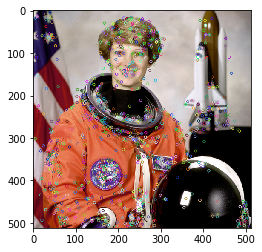

In [60]:
image = data.astronaut()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
(kps , des) = sift.detectAndCompute(gray , None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))
sift_image = cv2.drawKeypoints(image , kps, image)
plt.imshow(sift_image)

# Surf

<a id='section8'></a>

# kps: 1718, descriptors: (202, 64)


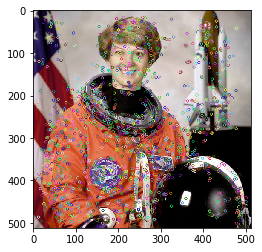

In [57]:
image = data.astronaut()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
surf = cv2.xfeatures2d.SURF_create()
(kps , des) = surf.detectAndCompute(gray , None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))
surf_image = cv2.drawKeypoints(image , kps, image)
plt.imshow(surf_image)

# ORB

<a id='section9'></a>

In [5]:
from skimage import data
from skimage import transform as tf
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

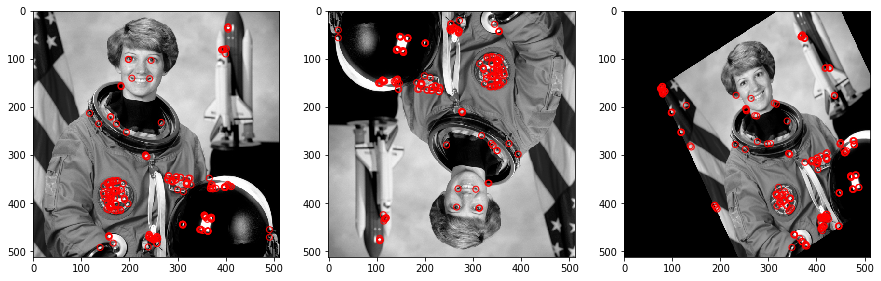

In [44]:
img1 = data.astronaut()
img1 = rgb2gray(img1)
img2 = tf.rotate(img1, 180)
tform = tf.AffineTransform(scale = (1.3,1.1), rotation = 0.5, translation=(0,-200))

img3 = tf.warp(img1, tform)


descriptor_extractor = ORB(n_keypoints=200)



descriptor_extractor.detect_and_extract(img1)
keypoint1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoint2 = descriptor_extractor.keypoints
descriptor2 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img3)
keypoint3 = descriptor_extractor.keypoints
descriptors3 = descriptor_extractor.descriptors


fig, ax = plt.subplots(1,3, figsize = (15,15))

ax[0].imshow(img1)
ax[0].scatter(keypoint1[:,1],keypoint1[:,0],facecolors = 'none',edgecolors = 'r')
ax[1].imshow(img2)
ax[1].scatter(keypoint2[:,1], keypoint2[:,0], facecolors = 'none',edgecolors='r')
ax[2].imshow(img3)
ax[2].scatter(keypoint3[:,1], keypoint3[:,0], facecolors = 'none', edgecolors = 'r')

# Brisk

# kps: 2029, descriptors: (2029, 64)


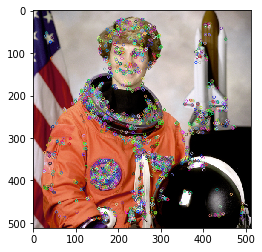

In [59]:
image = data.astronaut()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
brisk = cv2.BRISK_create()
(kps, descs) = brisk.detectAndCompute(gray, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))
brisk_image = cv2.drawKeypoints(image , kps,image)
plt.imshow(brisk_image)

# Using Entropy

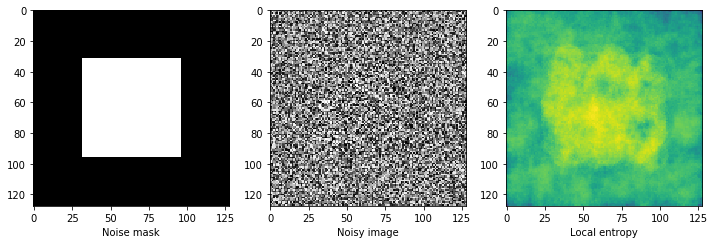

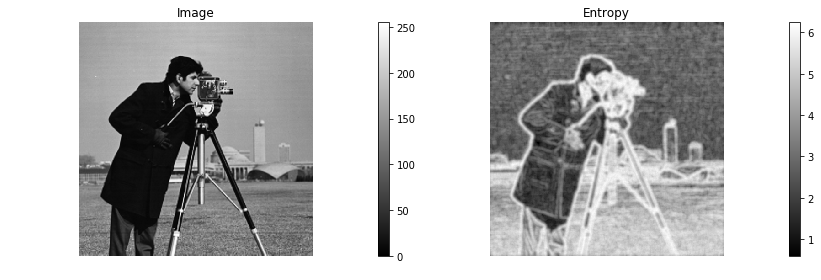

In [75]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk

# First example: object detection.

noise_mask = 28 * np.ones((128, 128), dtype=np.uint8)
noise_mask[32:-32, 32:-32] = 30

noise = (noise_mask * np.random.random(noise_mask.shape) - 0.5 *
         noise_mask).astype(np.uint8)
img = noise + 128

entr_img = entropy(img, disk(10))

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax0.imshow(noise_mask, cmap='gray')
ax0.set_xlabel("Noise mask")
ax1.imshow(img, cmap='gray')
ax1.set_xlabel("Noisy image")
ax2.imshow(entr_img, cmap='viridis')
ax2.set_xlabel("Local entropy")

fig.tight_layout()

# Second example: texture detection.

image = img_as_ubyte(data.camera())

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4),
                               sharex=True, sharey=True)

img0 = ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title("Image")
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

img1 = ax1.imshow(entropy(image, disk(5)), cmap='gray')
ax1.set_title("Entropy")
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

fig.tight_layout()

plt.show()

<a id='section11'></a>

# 동시 발생행렬 만들기

In [92]:
image = np.array([[0, 0, 1, 1],
...                   [0, 0, 1, 1],
...                   [0, 2, 2, 2],
...                   [2, 2, 3, 3]], dtype=np.uint8)

result = esult = greycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4],levels=4)

In [93]:
 g = greycomatrix(image, [1, 2], [0, np.pi/2], levels=4,
...                  normed=True, symmetric=True)

contrast = greycoprops(g, 'contrast')
contrast

array([[ 0.58333333,  1.        ],
       [ 1.25      ,  2.75      ]])

# LBP 직렬형 분류기 코드

<a id='section12'></a>

Rotated images matched against references using LBP:
original: brick, rotated: 30deg, match result:  brick
original: brick, rotated: 70deg, match result:  brick
original: grass, rotated: 145deg, match result:  grass


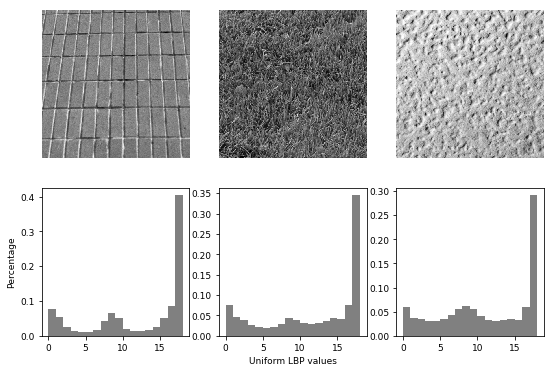

In [118]:
# settings for LBP
radius = 2
n_points = 8 * radius
METHOD = 'uniform'

def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))


def match(refs, img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, normed=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, normed=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name

def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


brick = data.load('brick.png')
grass = data.load('grass.png')
wall = data.load('rough-wall.png')

refs = {
    'brick': local_binary_pattern(brick, n_points, radius, METHOD),
    'grass': local_binary_pattern(grass, n_points, radius, METHOD),
    'wall': local_binary_pattern(wall, n_points, radius, METHOD)
}

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: brick, rotated: 30deg, match result: ',
      match(refs, rotate(brick, angle=30, resize=False)))
print('original: brick, rotated: 70deg, match result: ',
      match(refs, rotate(brick, angle=70, resize=False)))
print('original: grass, rotated: 145deg, match result: ',
      match(refs, rotate(grass, angle=145, resize=False)))

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,
                                                       figsize=(9, 6))
plt.gray()

ax1.imshow(brick)
ax1.axis('off')
hist(ax4, refs['brick'])
ax4.set_ylabel('Percentage')

ax2.imshow(grass)
ax2.axis('off')
hist(ax5, refs['grass'])
ax5.set_xlabel('Uniform LBP values')

ax3.imshow(wall)
ax3.axis('off')
hist(ax6, refs['wall'])

plt.show()

# PCA - face recognition

In [94]:
import matplotlib.pyplot as plt
 
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
 
 
# Load data
lfw_dataset = fetch_lfw_people(min_faces_per_person=100)
 
_, h, w = lfw_dataset.images.shape
X = lfw_dataset.data
y = lfw_dataset.target
target_names = lfw_dataset.target_names
 
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [95]:
# Compute a PCA 
n_components = 100
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
 
# apply PCA transformation
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [96]:
# train a neural network
print("Fitting the classifier to the training set")
clf = MLPClassifier(hidden_layer_sizes=(1024,), batch_size=256, verbose=True, early_stopping=True).fit(X_train_pca, y_train)

Fitting the classifier to the training set
Iteration 1, loss = 1.47776693
Validation score: 0.550000
Iteration 2, loss = 1.10729020
Validation score: 0.600000
Iteration 3, loss = 0.88644885
Validation score: 0.737500
Iteration 4, loss = 0.69945750
Validation score: 0.750000
Iteration 5, loss = 0.55320926
Validation score: 0.812500
Iteration 6, loss = 0.44359800
Validation score: 0.800000
Iteration 7, loss = 0.35913834
Validation score: 0.825000
Iteration 8, loss = 0.29231435
Validation score: 0.862500
Iteration 9, loss = 0.24021968
Validation score: 0.850000
Iteration 10, loss = 0.20067427
Validation score: 0.862500
Iteration 11, loss = 0.16857030
Validation score: 0.862500
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


In [97]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.91      0.85      0.88        72
  Donald Rumsfeld       0.96      0.66      0.78        35
    George W Bush       0.83      0.96      0.89       157
Gerhard Schroeder       0.94      0.81      0.87        37
       Tony Blair       0.77      0.73      0.75        41

      avg / total       0.87      0.86      0.86       342



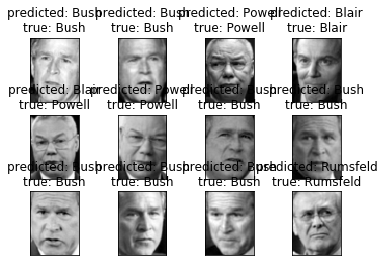

In [98]:
# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
 
def titles(y_pred, y_test, target_names):
    for i in range(y_pred.shape[0]):
        pred_name = target_names[y_pred[i]].split(' ')[-1]
        true_name = target_names[y_test[i]].split(' ')[-1]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)
 
prediction_titles = list(titles(y_pred, y_test, target_names))
plot_gallery(X_test, prediction_titles, h, w)

# Another Example

(400, 4096)


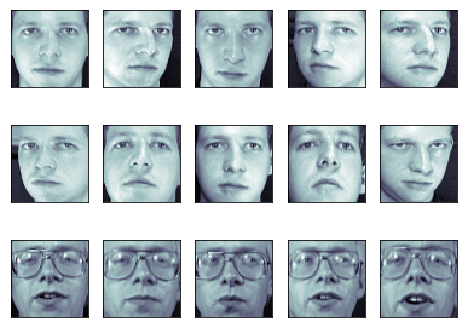

In [117]:
from sklearn import datasets
faces = datasets.fetch_olivetti_faces() # image data loading 
print(faces.data.shape)

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)


In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(faces.data,
        faces.target, random_state=0) # training and test data setting. label is faces target 

print(X_train.shape, X_test.shape) # training data : 300 , testing data : 100

(300, 4096) (100, 4096)


In [102]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

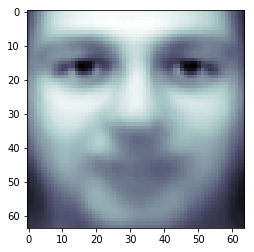

In [103]:
plt.imshow(pca.mean_.reshape(faces.images[0].shape),
           cmap=plt.cm.bone)

In [104]:
print(pca.components_.shape)

(150, 4096)


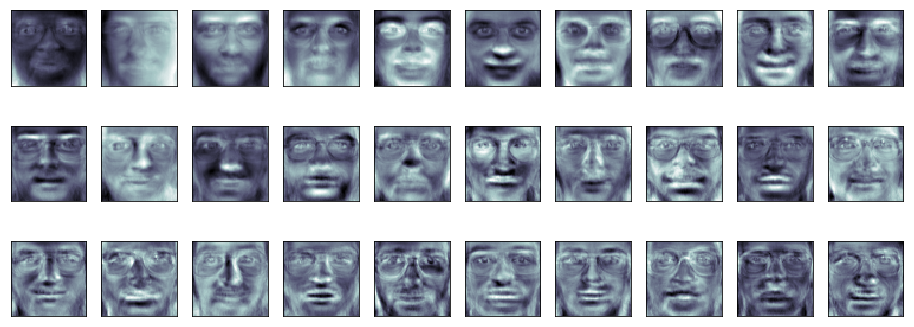

In [105]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)

In [108]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)
print(X_test_pca.shape)


(100, 150)


In [109]:
from sklearn import svm
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

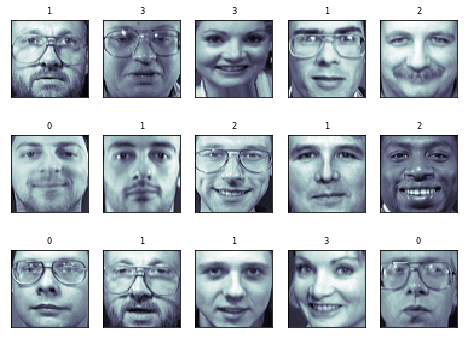

In [111]:
import numpy as np
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(faces.target[y_pred],
                 fontsize='small', color=color)

In [112]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      0.67      0.80         6
          1       1.00      1.00      1.00         4
          2       0.50      1.00      0.67         2
          3       1.00      1.00      1.00         1
          4       0.33      1.00      0.50         1
          5       1.00      1.00      1.00         5
          6       1.00      1.00      1.00         4
          7       1.00      0.67      0.80         3
          9       1.00      1.00      1.00         1
         10       1.00      1.00      1.00         4
         11       1.00      1.00      1.00         1
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00         3
         14       1.00      1.00      1.00         5
         15       0.75      1.00      0.86         3
         17       1.00      1.00      1.00         6
         19       1.00      1.00      1.00         4
         20       1.00      1.00      1.00   

In [113]:
from sklearn.pipeline import Pipeline
clf = Pipeline([('pca', decomposition.PCA(n_components=150, whiten=True)),
                ('svm', svm.LinearSVC(C=1.0))])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(metrics.confusion_matrix(y_pred, y_test))
plt.show()

[[2 0 0 ..., 0 0 0]
 [0 4 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 3 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 3]]
